In [123]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from gpytorch.priors import GammaPrior
import torch
import optuna
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import gpytorch
torch.manual_seed(42)

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RQKernel(lengthscale = 1.551042261369384), num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [95]:
data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'final_data_log_targets.csv'))

df.head()

,TAU_bl,PTAU_bl,ABETA_bl,PTEDUCAT,MMSE_bl,EcogPtTotal_bl,LDELTOTAL_BL,mPACCdigit_bl,mPACCtrailsB_bl,RAVLT_immediate_bl,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,4.617099,2.310553,731.8,-1.0,-2.0,-0.179246,15.0,1.722587,1.525525,0.440843,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
1,5.783210,3.537766,780.3,-2.0,-3.0,0.216812,7.0,0.221907,0.032151,0.582690,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
2,6.195221,3.973682,832.7,0.5,0.5,-0.275793,3.0,-1.111149,-1.035326,-0.784427,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
3,4.683981,2.356126,590.4,3.0,3.0,-0.545607,11.0,0.306061,0.339234,0.002003,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
4,5.509793,3.210037,466.1,1.0,0.5,0.040211,18.0,1.883734,1.336483,0.512023,...,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675


In [96]:

X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df.filter(['ABETA_bl','PTAU_bl', 'TAU_bl'])


scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(434, 175) (109, 175) (434, 3) (109, 3)


In [97]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
noise_prior = GammaPrior(concentration=1.1, rate=0.05)
num_tasks = 3
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks, rank=1, noise_prior=noise_prior)
#with torch.no_grad():
#    likelihood.raw_noise.data.fill_(-5.0)
model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)


mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

initial_likelihood = mll(model(X_train), y_train)
while initial_likelihood < -1.5:
    model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)
    initial_likelihood = mll(model(X_train), y_train)
print(f'Model finially intialized with likelihood: {initial_likelihood}')


model.train()
likelihood.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00765928291339757, weight_decay = 0.005854636585988225, maximize=True)


# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50], gamma=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=21)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.4099368005729661,patience=20)

Model finially intialized with likelihood: -1.4846689701080322


In [111]:
training_loss = []
test_losses = []

In [112]:

num_iter = 1000
for i in range(num_iter):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = mll(output, y_train)
    loss.backward()
    training_loss.append(loss.item())
    
    optimizer.step()
    model.eval()
    test_output = model(X_test)
    test_loss = mll(test_output, y_test)
    test_losses.append(test_loss.item())
    
    scheduler.step(mll(output, y_train))
    print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))

# Evaluation
model.eval()
likelihood.eval()



Iter 1/1000 - Loss: -1.485
Iter 2/1000 - Loss: -1.481
Iter 3/1000 - Loss: -1.477
Iter 4/1000 - Loss: -1.473
Iter 5/1000 - Loss: -1.468
Iter 6/1000 - Loss: -1.464
Iter 7/1000 - Loss: -1.460
Iter 8/1000 - Loss: -1.456
Iter 9/1000 - Loss: -1.452
Iter 10/1000 - Loss: -1.448
Iter 11/1000 - Loss: -1.445
Iter 12/1000 - Loss: -1.441
Iter 13/1000 - Loss: -1.437
Iter 14/1000 - Loss: -1.433
Iter 15/1000 - Loss: -1.429
Iter 16/1000 - Loss: -1.425
Iter 17/1000 - Loss: -1.421
Iter 18/1000 - Loss: -1.417
Iter 19/1000 - Loss: -1.413
Iter 20/1000 - Loss: -1.409
Iter 21/1000 - Loss: -1.406
Iter 22/1000 - Loss: -1.402
Iter 23/1000 - Loss: -1.398
Iter 24/1000 - Loss: -1.396
Iter 25/1000 - Loss: -1.395
Iter 26/1000 - Loss: -1.393
Iter 27/1000 - Loss: -1.392
Iter 28/1000 - Loss: -1.390
Iter 29/1000 - Loss: -1.388
Iter 30/1000 - Loss: -1.387
Iter 31/1000 - Loss: -1.385
Iter 32/1000 - Loss: -1.384
Iter 33/1000 - Loss: -1.382
Iter 34/1000 - Loss: -1.381
Iter 35/1000 - Loss: -1.379
Iter 36/1000 - Loss: -1.378
I

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
  (raw_noise_prior): GammaPrior()
)

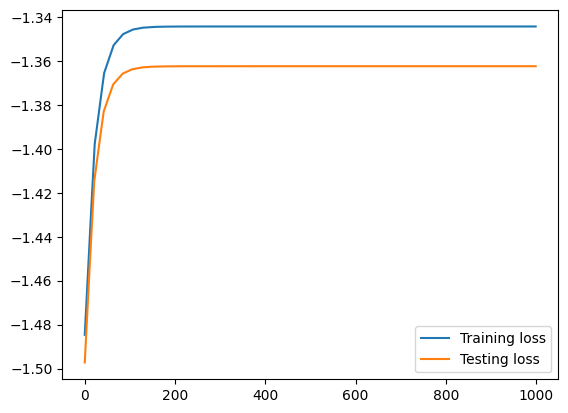

In [113]:
plt.plot(training_loss, label='Training loss')
plt.plot(test_losses,label='Testing loss')
plt.legend()
plt.show()

In [91]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.tolist()}')

Parameter name: likelihood.task_noise_covar_factor         value = [[0.31400904059410095], [0.4082892835140228], [0.4701519012451172]]
Parameter name: likelihood.raw_noise                       value = [-4.749917507171631]
Parameter name: covar_module.task_covar_module.covar_factor value = [[0.054300714284181595], [1.1496092081069946], [1.148325800895691]]
Parameter name: covar_module.task_covar_module.raw_var     value = [0.5796663165092468, -5.438444137573242, -4.7183403968811035]
Parameter name: covar_module.data_covar_module.raw_lengthscale value = [[3.279832363128662]]
Parameter name: covar_module.data_covar_module.raw_alpha   value = [-2.39493989944458]


In [92]:
with torch.no_grad():
    preds = model(X_train)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_train.numpy()
y_pred_np = mean.numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")

Target 1: MSE = 0.0514, RMSE = 0.2268, R2 = 0.9475
Target 2: MSE = 0.0765, RMSE = 0.2766, R2 = 0.9216
Target 3: MSE = 0.1257, RMSE = 0.3545, R2 = 0.8700


c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Target 1: MSE = 0.4142, RMSE = 0.6436, R2 = 0.6169
Target 2: MSE = 0.6833, RMSE = 0.8266, R2 = 0.3753
Target 3: MSE = 0.7892, RMSE = 0.8884, R2 = 0.3028


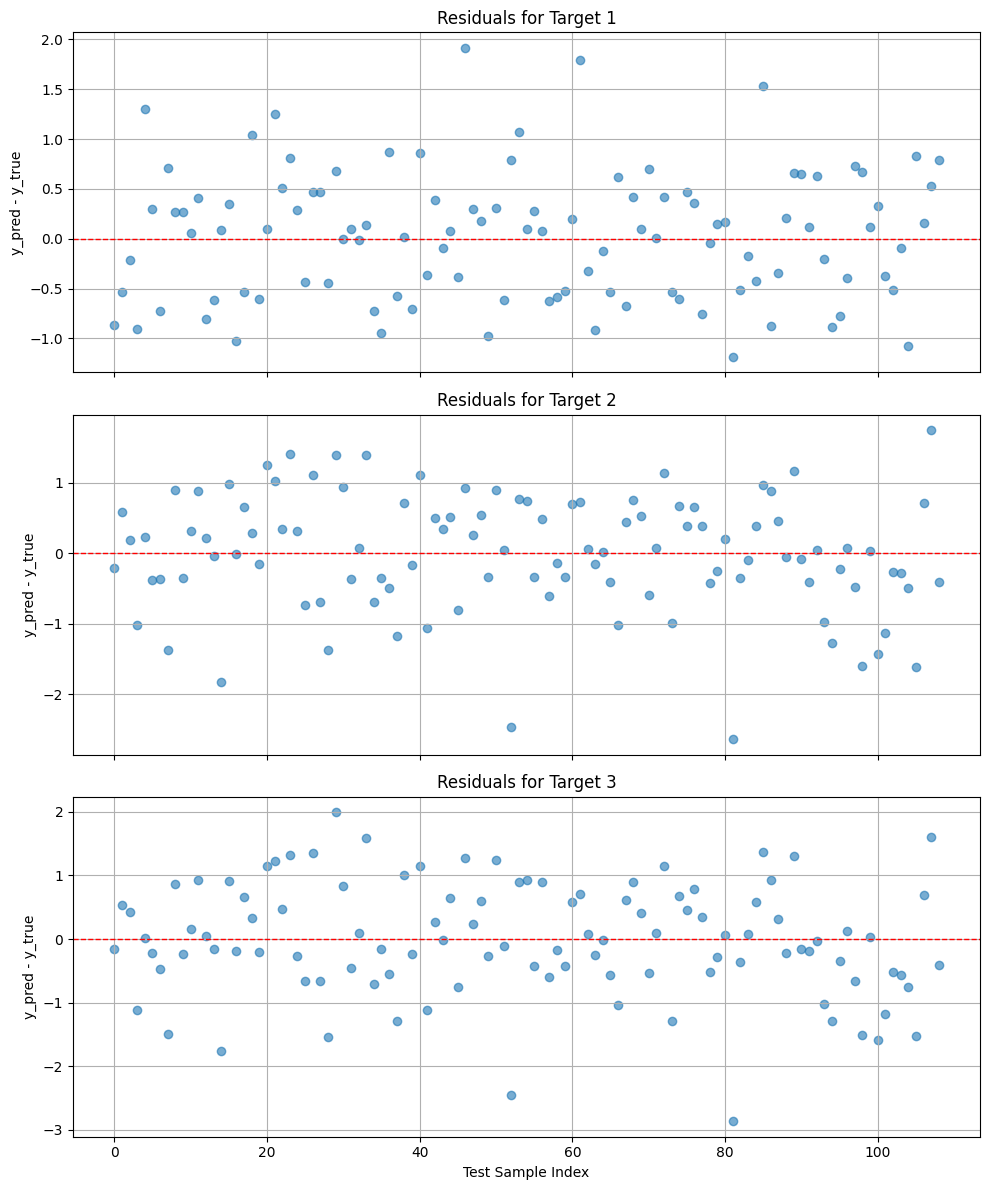

In [93]:
with torch.no_grad():
    preds = model(X_test)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_test.numpy()
y_pred_np = mean.numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")
    

y_true_np = y_test.numpy()
y_pred_np = mean.numpy()

num_targets = y_true_np.shape[1]

# Plot residuals for each target
fig, axs = plt.subplots(num_targets, 1, figsize=(10, 4 * num_targets), sharex=True)

for i in range(num_targets):
    residuals = y_pred_np[:, i] - y_true_np[:, i]

    axs[i].scatter(range(len(residuals)), residuals, alpha=0.6)
    axs[i].axhline(0, color='red', linestyle='--', linewidth=1)
    axs[i].set_title(f"Residuals for Target {i+1}")
    axs[i].set_ylabel("y_pred - y_true")
    axs[i].grid(True)

plt.xlabel("Test Sample Index")
plt.tight_layout()
plt.show()

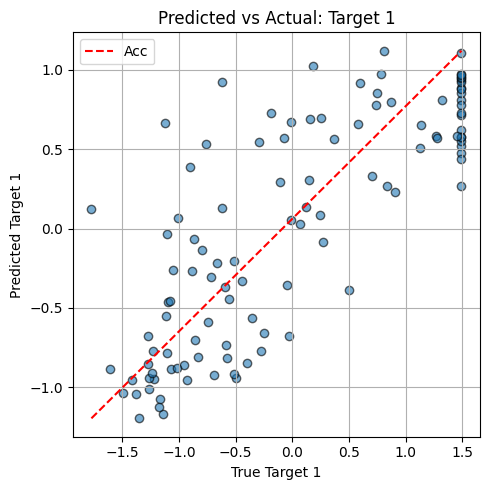

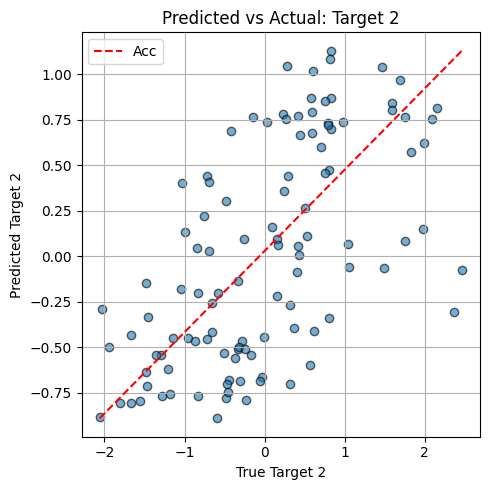

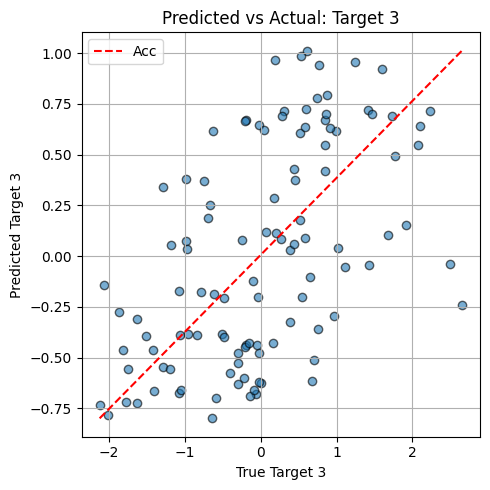

In [25]:
for i in range(y_test.shape[1]):
    plt.figure(figsize=(5, 5))
    plt.scatter(y_test[:, i].numpy(), mean[:, i].numpy(), alpha=0.6, edgecolors='k')
    plt.plot([y_test[:, i].min(), y_test[:, i].max()],
             [y_pred_np[:, i].min(), y_pred_np[:, i].max()], 'r--', label='Acc')

    plt.xlabel(f"True Target {i+1}")
    plt.ylabel(f"Predicted Target {i+1}")
    plt.title(f"Predicted vs Actual: Target {i+1}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# STL
## ABETA


In [153]:
import mrmr

In [165]:
class MulittaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RQKernel(lengthscale = 0.0889674883546093), num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


In [166]:
data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'final_data_log_targets.csv'))

df.head()

X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df.filter(['ABETA_bl'])

features = mrmr.mrmr_regression(X, y, K =43)

scaler = StandardScaler()
X = scaler.fit_transform(X[features])
y = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print(features)

100%|██████████| 43/43 [00:01<00:00, 33.56it/s]

(434, 43) (109, 43) (434, 1) (109, 1)
['SUVr_Precuneus_L.nii', 'SUVr_Thal_AV_R.nii', 'SUVr_Precuneus_R.nii', 'SUVr_Fusiform_L.nii', 'SUVr_Parietal_Sup_L.nii', 'SUVr_Parietal_Inf_R.nii', 'SUVr_Angular_L.nii', 'SUVr_Fusiform_R.nii', 'SUVr_Angular_R.nii', 'SUVr_ACC_pre_L.nii', 'mPACCtrailsB_bl', 'SUVr_ACC_sub_L.nii', 'SUVr_Parietal_Inf_L.nii', 'SUVr_Temporal_Mid_R.nii', 'SUVr_Lingual_L.nii', 'SUVr_Parietal_Sup_R.nii', 'SUVr_ACC_sub_R.nii', 'SUVr_Temporal_Inf_L.nii', 'SUVr_Thal_AV_L.nii', 'SUVr_Temporal_Mid_L.nii', 'SUVr_ACC_pre_R.nii', 'SUVr_Occipital_Mid_L.nii', 'LDELTOTAL_BL', 'SUVr_Cingulate_Mid_L.nii', 'SUVr_Olfactory_L.nii', 'SUVr_Lingual_R.nii', 'SUVr_Temporal_Sup_R.nii', 'SUVr_Occipital_Mid_R.nii', 'SUVr_Supp_Motor_Area_L.nii', 'mPACCdigit_bl', 'SUVr_Temporal_Inf_R.nii', 'SUVr_Occipital_Inf_L.nii', 'SUVr_Frontal_Sup_2_R.nii', 'RAVLT_immediate_bl', 'SUVr_Rectus_L.nii', 'SUVr_Thal_LP_L.nii', 'SUVr_Frontal_Med_Orb_R.nii', 'SUVr_Olfactory_R.nii', 'SUVr_Rectus_R.nii', 'SUVr_Frontal_Sup_

In [167]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [168]:
noise_prior = GammaPrior(concentration=1.1, rate=0.05)
num_tasks = 1
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks, rank=1, noise_prior=noise_prior)
#with torch.no_grad():
#    likelihood.raw_noise.data.fill_(-5.0)
model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)


mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

initial_likelihood = mll(model(X_train), y_train)
while initial_likelihood < -165:
    model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)
    initial_likelihood = mll(model(X_train), y_train)
print(f'Model finially intialized with likelihood: {initial_likelihood}')


model.train()
likelihood.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.003557352777260118, weight_decay=2.1082803135082174e-05, maximize=True)


# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50], gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8365640518480437,patience=16)

Model finially intialized with likelihood: -1.3682210445404053


In [169]:
training_loss = []
test_losses = []

num_iter = 500
for i in range(num_iter):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = mll(output, y_train)
    loss.backward()
    training_loss.append(loss.item())
    
    optimizer.step()
    model.eval()
    test_output = model(X_test)
    test_loss = mll(test_output, y_test)
    test_losses.append(test_loss.item())
    
    scheduler.step(mll(output, y_train))
    print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))

# Evaluation
model.eval()
likelihood.eval()

Iter 1/500 - Loss: -1.368
Iter 2/500 - Loss: -1.366
Iter 3/500 - Loss: -1.364
Iter 4/500 - Loss: -1.361
Iter 5/500 - Loss: -1.359
Iter 6/500 - Loss: -1.357
Iter 7/500 - Loss: -1.354
Iter 8/500 - Loss: -1.352
Iter 9/500 - Loss: -1.350
Iter 10/500 - Loss: -1.347
Iter 11/500 - Loss: -1.345
Iter 12/500 - Loss: -1.343
Iter 13/500 - Loss: -1.341
Iter 14/500 - Loss: -1.338
Iter 15/500 - Loss: -1.336
Iter 16/500 - Loss: -1.334
Iter 17/500 - Loss: -1.332
Iter 18/500 - Loss: -1.329
Iter 19/500 - Loss: -1.327
Iter 20/500 - Loss: -1.325
Iter 21/500 - Loss: -1.323
Iter 22/500 - Loss: -1.321
Iter 23/500 - Loss: -1.320
Iter 24/500 - Loss: -1.318
Iter 25/500 - Loss: -1.316
Iter 26/500 - Loss: -1.314
Iter 27/500 - Loss: -1.312
Iter 28/500 - Loss: -1.310
Iter 29/500 - Loss: -1.309
Iter 30/500 - Loss: -1.307
Iter 31/500 - Loss: -1.305
Iter 32/500 - Loss: -1.303
Iter 33/500 - Loss: -1.301
Iter 34/500 - Loss: -1.300
Iter 35/500 - Loss: -1.298
Iter 36/500 - Loss: -1.296
Iter 37/500 - Loss: -1.294
Iter 38/50

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
  (raw_noise_prior): GammaPrior()
)

In [170]:
with torch.no_grad():
    preds = model(X_train)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_train.numpy()
y_pred_np = mean.numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")

Target 1: MSE = 0.1118, RMSE = 0.3344, R2 = 0.8859


In [171]:
with torch.no_grad():
    preds = model(X_test)
    mean = preds.mean  # shape: (n, 3)

y_true_np = y_test.numpy()
y_pred_np = mean.numpy()

num_targets = y_true_np.shape[1]

for i in range(num_targets):
    mse = mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    rmse = root_mean_squared_error(y_true_np[:, i], y_pred_np[:, i])
    r2 = r2_score(y_true_np[:, i], y_pred_np[:, i])
    print(f"Target {i+1}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")
    

Target 1: MSE = 0.4564, RMSE = 0.6755, R2 = 0.5780


# Optimisation

In [173]:
data_dir = 'data'

df = pd.read_csv(os.path.join(data_dir, 'final_data_log_targets.csv'))

df.head()

X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df.filter(['ABETA_bl'])

features = mrmr.mrmr_regression(X, y, K =43)

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print(features)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


100%|██████████| 43/43 [00:02<00:00, 21.31it/s]

(434, 175) (109, 175) (434, 1) (109, 1)
['SUVr_Precuneus_L.nii', 'SUVr_Thal_AV_R.nii', 'SUVr_Precuneus_R.nii', 'SUVr_Fusiform_L.nii', 'SUVr_Parietal_Sup_L.nii', 'SUVr_Parietal_Inf_R.nii', 'SUVr_Angular_L.nii', 'SUVr_Fusiform_R.nii', 'SUVr_Angular_R.nii', 'SUVr_ACC_pre_L.nii', 'mPACCtrailsB_bl', 'SUVr_ACC_sub_L.nii', 'SUVr_Parietal_Inf_L.nii', 'SUVr_Temporal_Mid_R.nii', 'SUVr_Lingual_L.nii', 'SUVr_Parietal_Sup_R.nii', 'SUVr_ACC_sub_R.nii', 'SUVr_Temporal_Inf_L.nii', 'SUVr_Thal_AV_L.nii', 'SUVr_Temporal_Mid_L.nii', 'SUVr_ACC_pre_R.nii', 'SUVr_Occipital_Mid_L.nii', 'LDELTOTAL_BL', 'SUVr_Cingulate_Mid_L.nii', 'SUVr_Olfactory_L.nii', 'SUVr_Lingual_R.nii', 'SUVr_Temporal_Sup_R.nii', 'SUVr_Occipital_Mid_R.nii', 'SUVr_Supp_Motor_Area_L.nii', 'mPACCdigit_bl', 'SUVr_Temporal_Inf_R.nii', 'SUVr_Occipital_Inf_L.nii', 'SUVr_Frontal_Sup_2_R.nii', 'RAVLT_immediate_bl', 'SUVr_Rectus_L.nii', 'SUVr_Thal_LP_L.nii', 'SUVr_Frontal_Med_Orb_R.nii', 'SUVr_Olfactory_R.nii', 'SUVr_Rectus_R.nii', 'SUVr_Frontal_Su

In [ ]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    # weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
    # optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD"])
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW"])
    scheduler_type = trial.suggest_categorical("scheduler", ["ReduceLROnPlateau", "CosineAnnealingLR"])
    lengthscale = trial.suggest_float("lengthscale", 1e-3, 1e1, log=True)

    num_tasks = 1
    noise_prior = GammaPrior(concentration=1.1, rate=0.05)
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks, rank=1, noise_prior=noise_prior)

    class TrialMultitaskGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, num_tasks):
            super(TrialMultitaskGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.MultitaskMean(
                gpytorch.means.ZeroMean(), num_tasks=num_tasks
            )
            self.covar_module = gpytorch.kernels.MultitaskKernel(
                gpytorch.kernels.RQKernel(lengthscale=lengthscale), num_tasks=num_tasks, rank=1
            )

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    model = TrialMultitaskGPModel(X_train, y_train, likelihood, num_tasks)


    # Configure optimizer
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, maximize=True)
    elif optimizer_name == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, maximize=True)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9, maximize=True)

    # Configure scheduler
    if scheduler_type == "ReduceLROnPlateau":
        factor = trial.suggest_float("factor", 0.1, 0.9)
        patience = trial.suggest_int("patience", 3, 20)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=factor, patience=patience, threshold=1e-4)
    elif scheduler_type == "StepLR":
        step_size = trial.suggest_int("step_size", 5, 50)
        gamma = trial.suggest_float("gamma", 0.1, 0.9)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    else:
        t_max = trial.suggest_int("t_max", 5, 50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=t_max)

    # Loss function
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    initial_likelihood = mll(model(X_train), y_train)
    while initial_likelihood < -1.75:
        model = MultitaskGPModel(X_train, y_train, likelihood, num_tasks)
        initial_likelihood = mll(model(X_train), y_train)
    print(f'Model finially intialized with likelihood: {initial_likelihood}')

    # Train the model
    model.train()
    likelihood.train()

    num_iter = 500  # You could also make this a hyperparameter

    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(X_train)
        loss = mll(output, y_train)
        loss.backward()
        optimizer.step()

        # Handle different scheduler types
        if scheduler_type == "ReduceLROnPlateau":
            scheduler.step(mll(output, y_train))  # Pass validation metric
        else:
            scheduler.step()

        # Report intermediate values for pruning
        if i % 20 == 0:
            trial.report(-loss.item(), i)

            # Enable pruning of unpromising trials
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    # Evaluate on test set
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = model(X_test)
        mean = preds.mean

    y_true_np = y_test.cpu().numpy()
    y_pred_np = mean.cpu().numpy()

    # Calculate mean R² across all targets
    r2_values = [r2_score(y_true_np[:, i], y_pred_np[:, i]) for i in range(num_tasks)]
    mean_r2 = np.mean(r2_values)

    return mean_r2  # Return metric to maximize

# Create study object and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f"  R² Score: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-02 14:45:41,149] A new study created in memory with name: no-name-9fb66681-5ac3-457d-b55e-8149696ca2c6


Model finially intialized with likelihood: -1.3708152770996094


[I 2025-07-02 14:46:15,209] Trial 0 finished with value: 0.6157397031784058 and parameters: {'lr': 0.010773869565594424, 'weight_decay': 0.0002369449277233316, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 0.002141211124019397, 'factor': 0.20355732732189732, 'patience': 14}. Best is trial 0 with value: 0.6157397031784058.


Model finially intialized with likelihood: -1.3653594255447388


[I 2025-07-02 14:46:50,826] Trial 1 finished with value: 0.6260499954223633 and parameters: {'lr': 0.08309404657278396, 'weight_decay': 0.00018760729926464026, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 0.05622282833009046, 'factor': 0.4051028463557679, 'patience': 3}. Best is trial 1 with value: 0.6260499954223633.


Model finially intialized with likelihood: -1.3841357231140137


[I 2025-07-02 14:47:23,617] Trial 2 finished with value: 0.5618767738342285 and parameters: {'lr': 0.002322771525519036, 'weight_decay': 5.728237686748092e-05, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 0.024665336628403554, 'factor': 0.825294029970519, 'patience': 5}. Best is trial 1 with value: 0.6260499954223633.


Model finially intialized with likelihood: -1.4721810817718506


[I 2025-07-02 14:47:54,691] Trial 3 finished with value: 0.4351290464401245 and parameters: {'lr': 0.0054778883228059246, 'weight_decay': 0.00019067314511837354, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 1.0497028840983205, 'factor': 0.4011749724306013, 'patience': 20}. Best is trial 1 with value: 0.6260499954223633.


Model finially intialized with likelihood: -1.5429311990737915


[I 2025-07-02 14:48:25,551] Trial 4 finished with value: 0.3837392330169678 and parameters: {'lr': 0.00045218849668887716, 'weight_decay': 0.0002890635056290461, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 1.560323292306092, 'factor': 0.8639642506412701, 'patience': 5}. Best is trial 1 with value: 0.6260499954223633.


Model finially intialized with likelihood: -1.7345472574234009


[I 2025-07-02 14:48:58,458] Trial 5 finished with value: 0.4028826951980591 and parameters: {'lr': 0.0038457439288837585, 'weight_decay': 1.1243980038801444e-05, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 0.001490963561937635, 'factor': 0.15260981574544, 'patience': 5}. Best is trial 1 with value: 0.6260499954223633.


Model finially intialized with likelihood: -1.4460532665252686


[I 2025-07-02 14:49:30,493] Trial 6 finished with value: 0.6073925495147705 and parameters: {'lr': 0.006664233278370008, 'weight_decay': 0.0002986856057331002, 'optimizer': 'AdamW', 'scheduler': 'ReduceLROnPlateau', 'lengthscale': 0.07901635005332955, 'factor': 0.2090759934105024, 'patience': 15}. Best is trial 1 with value: 0.6260499954223633.
[I 2025-07-02 14:49:30,591] Trial 7 pruned. 


Model finially intialized with likelihood: -1.3806952238082886
